## 03 – Point forecasts

In this notebook I turn the engineered features into concrete forecasting
models for German system load. I:

1. Build 1-hour-ahead and 24-hour-ahead supervised datasets.
2. Split the data chronologically into training and test sets.
3. Compare simple baselines (persistence and same-hour-last-week) to a
   gradient boosting regression model.
4. Visualize a sample test week to see where the models succeed or fail.

This establishes a strong point-forecast baseline before adding
probabilistic methods in the next notebook.


## 3.1 Load data and construct 1-hour-ahead features

We start by loading the cleaned OPSD time series and using the feature
engineering helpers from Notebook 02 to build a supervised learning table
for 1-hour-ahead load forecasting. Each row corresponds to time *t*, with
features summarizing the recent history and calendar context, and a target
equal to load at time *t + 1h*.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data import load_opsd_germany
from src.features import make_features
from src.models import train_point_model
from src.evaluation import regression_metrics

# Load data & build 1h-ahead features
raw = load_opsd_germany(str(PROJECT_ROOT / "data" / "time_series_60min_singleindex.csv"))
X, y = make_features(raw, horizon=1, target_col="load")


## 3.2 Train–test split by time

To mimic a realistic forecasting setup, I split the data chronologically:
the first 80% of timestamps are used for training and the last 20% for
testing. This avoids leaking future information into the past.

In [ ]:
# Time-based train/test split (80/20 by time index)
cutoff = X.index[int(0.8 * len(X))]
X_train = X[X.index < cutoff]
y_train = y[y.index < cutoff]
X_test = X[X.index >= cutoff]
y_test = y[y.index >= cutoff]
X_train.shape, X_test.shape


((39944, 28), (9986, 28))

## 3.3 Baseline models and gradient boosting

I compare three point-forecasting approaches:

- **Persistence:** predict that the next hour's load equals the current load.
- **Same-hour-last-week:** predict using the load from the same hour one week ago.
- **Gradient Boosting:** a tree-based regression model trained on all
  engineered features (lags, rolling statistics, and calendar variables).

The baselines capture short-term and weekly persistence; the boosted trees
can combine all signals in a flexible way.

In [8]:
# Naive baselines
# Persistence: y_hat(t+1) = load at time t
y_pred_persist = X_test["load"].values

# Same-hour-last-week: use lag_168 if available
if "load_lag_168" in X_test.columns:
    y_pred_week = X_test["load_lag_168"].values
else:
    y_pred_week = y_pred_persist.copy()


In [9]:
# Gradient boosting point model
point_model = train_point_model(X_train, y_train)
y_pred_gb = point_model.predict(X_test)


In [10]:
# Evaluate MAE & RMSE
metrics_persist = regression_metrics(y_test, y_pred_persist)
metrics_week = regression_metrics(y_test, y_pred_week)
metrics_gb = regression_metrics(y_test, y_pred_gb)

import pandas as pd
pd.DataFrame([metrics_persist, metrics_week, metrics_gb], index=["Persistence", "Same-hour-last-week", "GradientBoosting"])


,MAE,RMSE
Persistence,1880.146705,2465.128765
Same-hour-last-week,3124.026437,4575.471181
GradientBoosting,673.711326,898.088419


In [13]:
metrics_df = pd.DataFrame(
    [metrics_persist, metrics_week, metrics_gb],
    index=["Persistence", "Same-hour-last-week", "GradientBoosting"],
)

# Relative improvement vs persistence
base_mae = metrics_df.loc["Persistence", "MAE"]
base_rmse = metrics_df.loc["Persistence", "RMSE"]

metrics_df["MAE_improvement_%"] = 100 * (base_mae - metrics_df["MAE"]) / base_mae
metrics_df["RMSE_improvement_%"] = 100 * (base_rmse - metrics_df["RMSE"]) / base_rmse

metrics_df


,MAE,RMSE,MAE_improvement_%,RMSE_improvement_%
Persistence,1880.146705,2465.128765,0.000000,0.000000
Same-hour-last-week,3124.026437,4575.471181,-66.158653,-85.607796
GradientBoosting,673.711326,898.088419,64.167087,63.568296



Persistence and same-hour-last-week baselines are reasonably strong because
load is highly autocorrelated and follows a weekly cycle, but the gradient
boosting model still improves substantially on both: test MAE drops from
about 1.9 GW (persistence) to ~0.7 GW, and RMSE from ~2.5 GW to ~0.9 GW.
This indicates that combining short-term lags, weekly patterns, and rolling
statistics in a nonlinear model captures additional structure beyond simple
heuristics.

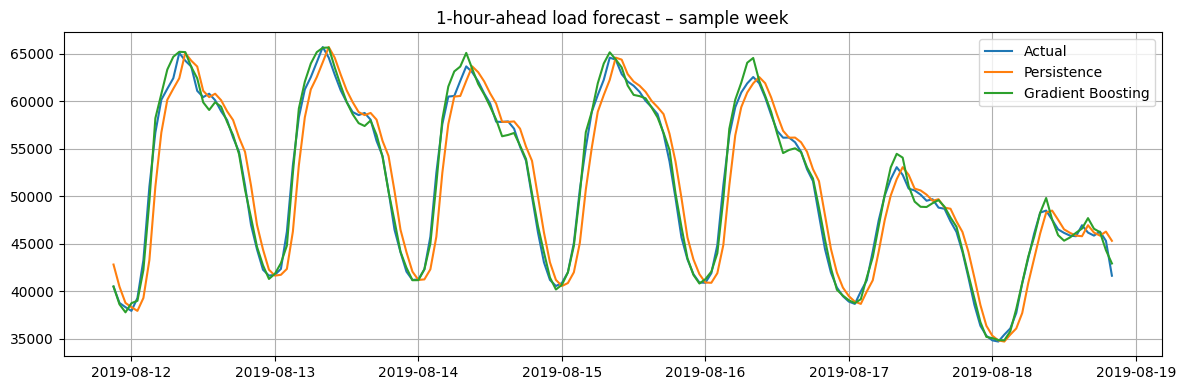

In [11]:
# Plot sample week
sample = slice(0, 7 * 24)  # first week of the test set
time = y_test.index[sample]
plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, y_pred_persist[sample], label="Persistence")
plt.plot(time, y_pred_gb[sample], label="Gradient Boosting")
plt.title("1-hour-ahead load forecast – sample week")
plt.legend()
plt.tight_layout()
plt.show()


The gradient boosting model (green) closely tracks the actual load curve,
capturing both the daily peaks and the overnight troughs. The persistence
baseline (orange) performs reasonably well but tends to lag during periods
of rapid change, such as the morning ramp-up and evening decline, which
leads to larger errors around the peaks and valleys. This qualitative view
is consistent with the quantitative metrics and illustrates where learned
models provide the most benefit.

## 3.4 Extending to 24-hour-ahead forecasts

I repeat the same pipeline for a 24-hour-ahead horizon. This is a more
difficult task: day-ahead planning is crucial for scheduling generation
and storage, but the system has more time to deviate from its recent
state.

In [12]:
# repeat for 24h horizon
X_24, y_24 = make_features(raw, horizon=24, target_col="load")

cutoff_24 = X_24.index[int(0.8 * len(X_24))]
X_train_24 = X_24[X_24.index < cutoff_24]
y_train_24 = y_24[y_24.index < cutoff_24]
X_test_24 = X_24[X_24.index >= cutoff_24]
y_test_24 = y_24[y_24.index >= cutoff_24]

# Baselines
y_pred_persist_24 = X_test_24["load"].values
y_pred_week_24 = X_test_24.get("load_lag_168", X_test_24["load"]).values

# Model
point_model_24 = train_point_model(X_train_24, y_train_24)
y_pred_gb_24 = point_model_24.predict(X_test_24)

# Metrics
import pandas as pd
metrics_24 = pd.DataFrame([
    regression_metrics(y_test_24, y_pred_persist_24),
    regression_metrics(y_test_24, y_pred_week_24),
    regression_metrics(y_test_24, y_pred_gb_24),
], index=["Persistence 24h", "Same-hour-last-week 24h", "GB 24h"]) 
metrics_24


,MAE,RMSE
Persistence 24h,4134.563514,6322.197120
Same-hour-last-week 24h,4894.350731,7137.936012
GB 24h,1699.169431,2462.592804


At a 24-hour horizon, all models perform worse in absolute terms, but the
relative gains from machine learning are even larger. The gradient boosting
model roughly halves both MAE and RMSE compared to the 24-hour persistence
baseline, and substantially outperforms the same-hour-last-week heuristic.
This suggests that the engineered features retain predictive value even at
longer horizons and that learned models can exploit it more effectively
than simple rules.